# L5d: Kernelized Support Vector Machines (kSVMs)
In this lab, we will experiment with a kernel Support Vector Machine (kSVM) to classify the non-linearly separable datasets we construct. In particular, we'll look at a kernelized version of the soft-margin support vector machine. If these terms are unfamiliar, [check out the L5c notes](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-5/L5c/docs/Notes.pdf) and the review below.

### Theory: Support Vector Machine (SVM)
Suppose, we have dataset $\mathcal{D} = \{(\hat{\mathbf{x}}_{i}, y_{i}) \mid i = 1,2,\dots,n\}$, where $\hat{\mathbf{x}}_i \in \mathbb{R}^p$ is an _augmented_ feature vector ($m$ features with additional `1` to model the bias on the end of the vector) and $y_i \in \{-1, 1\}$ is the corresponding class label. The goal of an SVM (for binary classification tasks) is to find the hyperplane $\mathcal{H}(\hat{\mathbf{x}}) = \{\hat{\mathbf{x}} \mid \left<\hat{\mathbf{x}},\theta\right> = 0\}$ that separates the data points into two classes (those points above the hyperplane, and those points below the hyperplane), where $\theta \in \mathbb{R}^{p}$ ($p=m+1$) is the normal vector to the hyperplane, or the parameters of the model that we need to estimate.
* __Why another method__? Support vector machines (SVMs) and other approaches, e.g., [the perceptron](https://en.wikipedia.org/wiki/Perceptron) differ primarily in their optimization objectives and training methods: while a [perceptron](https://en.wikipedia.org/wiki/Perceptron) can find _a hyperplane_ that separates classes, SVMs seek to find the _best hyperplane_ in the sense that the _margin_ between classes is maximized.

#### Soft margin
Let's take a look at a [schematic of the ideas behind a soft margin support vector machine](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-5/L5c/docs/figs/Fig-SVM-Schematic-Softmargin.pdf).
If the data is _not linearly separable_, then we know that a perfect $\mathcal{H}(\hat{\mathbf{x}})$ will not exist, i.e., 
no hyperplane will separate the data without making at least one mistake. In this case, we can estimate the _best_ hyperplane possible by solving the maximum soft margin problem given by:
$$
\begin{align*}
    \min_{\theta}\quad & \frac{1}{2}\lVert{\theta}\rVert_{2}^{2} + C\sum_{i=1}^{n}\xi_{i}\\
    \text{subject to}\quad & y_{i}\left<\hat{\mathbf{x}}_{i},\theta\right> \geq 1 - \xi_{i}\quad\forall i\\
    & \xi_{i} \geq 0\quad\forall i
\end{align*}
$$
where $\xi_{i}$ is a _slack variable_, that quantifies the cost of a classification mistake, and $C>{0}$ is a user-adjustable parameter that controls the trade-off between maximizing the margin and minimizing the slack variables.
* __Values of $C$__: If $C\gg{1}$ the classifier will behave like the maximum (hard) margin classifier, i.e., mistakes will be expensive, and the search will avoid making choices with mistakes. However, if $C\ll{1}$, the classifier will allow more slack (mistakes), i.e., mistakes are cheap, so what's it matter!

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (10 min)__: Let's take 10 minutes to explore how we will generate the datasets we'll explore today. We'll work through how to generate linearly separable and non-linearly separable datasets.
* __Task 2: Linear SVM classification (15 min)__: In this task, we [use the SVM implementation exported by the `LIBSVM.jl` package](https://github.com/JuliaML/LIBSVM.jl) to classify the dataset $\mathcal{D}$ generated in task 1 using a `linear kernel`. In particular, we use the `training` dataset to estimate the unknown model parameters $\theta$ [using the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl), and the `test` data to evaluate the performance of the classifier on unseen data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl).
* __Task 3: Implement a Grid Search to estimate the optimal hyperparameters for an RBF-SVM (15 min)__: In this task, we'll perform a grid search to estimate the best hyperparameters for a keneralized SVM using the RBF kernel. We'll estimate the best $C$ parameter in the objective function and the length-scale $\gamma$ parameter.

Let's get going!

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

### Data
In this section, we will build sample (binary) datasets $\mathcal{D} = \{(\hat{\mathbf{x}}_{i}, y_{i}) \mid i = 1,2,\dots,n\}$ to classify. Before we get started, we specify some constants that we use later:
* The `number_of_points_per_label::Int` variable controls the number of sample points in the dataset for each label. The total number of instances in $\mathcal{D}$ will be two times this number.
* The `number_of_training_examples::Int` variable controls the number of points we use for `training`, with the balance of the instances then going to `test`.
* The `number_of_features::Int` variable controls the number of features in the data, i.e., for $\mathbf{x}\in\mathbb{R}^{m}$, this value is `m`.
* The `ϵ::Float64` variable is a threshold value for including a not linearly separable data point into the dataset $\mathcal{D}$, i.e., it is the probability that if we generate data that is not separable, we include it in the dataset.

In [5]:
number_of_points_per_label = nothing; # this should be 1000; number of samples per label (2 x this is the total)
number_of_training_examples = nothing; # pick this many training examples at random
number_of_features = nothing; # we have this many features
ϵ = 0.05; # threshold of random NLS points to accept

Let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{-1,1\}$ while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

Next, let's write a code to generate a [non-lineraly separable data set](https://en.wikipedia.org/wiki/Linear_separability) $\mathcal{D}$ that we'll use to train (and test) our [kSVM](https://en.wikipedia.org/wiki/Support_vector_machine#Nonlinear_kernels).

* First, we generate a random parameter vector $\theta\in\mathbb{R}^{p}$ where $p = m+1$.
* Next, we generate (random) augmented feature vecotors $\hat{\mathbf{x}}\in\mathbb{R}^{p}$ and for specified labels, and check the $y\cdot\left(\hat{\mathbf{x}}^{\top}\mathbf{\theta}\right) \geq 0$ condition. If this condition is true, we `accept` that data; otherwise, we `reject` the data. If we `accept` the data, we store it in the `dataset` variable, a [Set](https://docs.julialang.org/en/v1/base/collections/#Base.Set) holding a [NamedTuple type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple), which is a mix of a tuple and a dictionary. If we `reject` the data, we roll a random number and compare it to the `ϵ::Float64` threshold value. If the random number is less than or equal to `ϵ::Float64`, we keep the rejected sample (and add it to the sample archive).
* We keep iterating the loop until the number of elements of the `dataset` is greater than or equal to the desired number of test points specified in the `number_of_points_per_label` variable.

We return the dataset $\mathcal{D}$ in the `D::Array{Float64,2}` array, where each row is an example, each column is a feature, except for the last column, which is the label.

In [9]:
D = let

    # initialize 
    dataset = Set{@NamedTuple{x::Array{Float64,1},y::Int64}}();
    w = randn(number_of_features+1); # tmp parameters that we use to make data

    # Logic to generate y = 1 samples
    should_keep_looping = true;
    y = 1; # label for this section
    while (should_keep_looping == true)
        x = randn(number_of_features) |> x -> push!(x,1); # generate a random augmented feature vector
        
        # check -
        if (y*(sum(w.*x)) ≥ 0.0)
            data = (x = x, y = y); # use a tuple, and set to enforce unique
            push!(dataset,data);
        else
            # failed!, Hmmmm. Should we keep this data??
            if (rand() ≤ ϵ)
                data = (x = x, y = y); # use a tuple, and set to enforce unique
                push!(dataset,data);
            end
        end
    
        # if we have enough examples, stop iterating
        if (length(dataset) >= number_of_points_per_label)
            should_keep_looping = false
        end
    end

    # Logic to generate y = -1 samples
    should_keep_looping = true;
    y = -1; # label for this section
    while (should_keep_looping == true)
        x = randn(number_of_features) |> x -> push!(x,1); # generate a random augmented feature vector
        
        # check -
        if (y*(sum(w.*x)) ≥ 0.0) # this is a LS point, keep
            data = (x = x, y = y); # use a tuple, and set to enforce unique
            push!(dataset,data);
        else
            # failed!, Hmmmm. Should we keep this data??
            if (rand() ≤ ϵ)
                data = (x = x, y = y); # use a tuple, and set to enforce unique
                push!(dataset,data);
            end
        end
    
        # If we have enough examples, stop iterating
        if (length(dataset) >= 2*number_of_points_per_label)
            should_keep_looping = false
        end
    end

    # ok, so let's put this data into a matrix -
    D = Array{Float64,2}(undef, 2*number_of_points_per_label, number_of_features+1);
    for i ∈ 1:2*number_of_points_per_label
        example = pop!(dataset);
        feature = example.x;
        label = example.y;
        for j ∈ 1:number_of_features
            D[i,j] = feature[j];
        end
        D[i,end] = label;
    end
    D
end

2000×3 Matrix{Float64}:
  2.29772   -0.666947   -1.0
 -0.691937  -1.02754    -1.0
 -0.851278  -0.145464    1.0
  1.11757   -2.58899    -1.0
 -1.74809   -0.145308    1.0
 -1.40699    2.02584     1.0
 -0.574229   0.869726    1.0
 -0.388563   1.74926     1.0
 -0.256088  -0.772835   -1.0
  0.38063   -0.699538   -1.0
 -0.229218  -0.770569   -1.0
  1.3412     0.422044    1.0
 -0.305915  -1.0578     -1.0
  ⋮                     
  0.67307   -0.97073    -1.0
 -1.04742    0.186543    1.0
 -0.042391   1.04092     1.0
  0.674619   1.02861     1.0
 -0.311397  -0.0126225   1.0
  0.741902  -0.994069   -1.0
 -0.33165    0.29882     1.0
  1.41413   -1.06403    -1.0
 -1.0207    -0.0690054   1.0
 -1.14391    2.52441     1.0
 -1.22991   -1.45427    -1.0
  0.789279  -2.788      -1.0

### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D`, which contains two continuous features and a label. The color indicates the label.
* __Summary__: We will get a different pattern of $\pm{1}$ labels depending the `ϵ::Float64` value. The dark blue dots represent label `1`, while the orange data represents label `1`. Our classifier should be able to learn the mapping between the features and the labels for linearly separable datasets but may struggle with random outlier points.

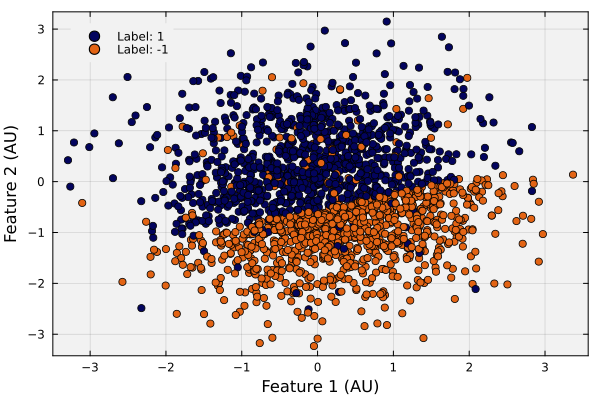

In [11]:
let

    dataset = D; # what dataset am I looking at?
    number_of_points_to_plot = size(dataset,1);
    if (number_of_features > 2)
        @info "Visualization disabled for more than 2 features!"
    else
        p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
        # plot label = 1
        testlabel = 1;
        i = findfirst(label -> label == testlabel,  dataset[:,3])
        c = my_color_dictionary[testlabel]
        scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)
    
        # plot label = -1
        testlabel = -1;
        i = findfirst(label -> label == testlabel,  dataset[:,3])
        c = my_color_dictionary[testlabel]
        scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)
    
        # plot all points
        for i ∈ 1:number_of_points_to_plot
            label = dataset[i,3]; # label
            c = my_color_dictionary[label]
            scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
        end
        
        xlabel!("Feature 1 (AU)", fontsize=18);
        ylabel!("Feature 2 (AU)", fontsize=18);
    end
end

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [13]:
training, test = let

    number_of_features = size(D,2); # number of cols of housing data
    number_of_examples = size(D,1); # number of rows of housing data
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

## Task 2: Classification using an Linear SVM
In this task, we [use the SVM implementation exported by the `LIBSVM.jl` package](https://github.com/JuliaML/LIBSVM.jl) to classify the dataset $\mathcal{D}$ generated in task 1 using a `linear kernel`. In particular, we use the `training` dataset to estimate the unknown model parameters $\theta$ [using the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl), and the `test` data to evaluate the performance of the classifier on unseen data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). 
* The [`svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) takes an augmented training examples matrix $\hat{\mathbf{X}}^{\top}$ where the examples are on the columns and the features are the rows, and a label vector $\mathbf{y}\in\left\{-1,1\right\}$.
* The [`svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) returns a [model instance](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) that holds the trained data and a bunch of other data associated with the problem.
* __Hmmm__: One of the (super) interesting optional arguments [the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) is the `kernel` argument. Check out the documentation to see what kernels are supported! Wow! we get [kernelized SVM capability](https://en.wikipedia.org/wiki/Support_vector_machine#Nonlinear_kernels) right out of the box. _Buy versus build, 99% buy!_

In [127]:
model = let

    # Setup the data that we are using
    D = training; # what dataset are we looking at?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y = D[:,end]; # label

    # TODO: Uncomment the line below to train the SVM model using the training data 
    # model = svmtrain(X, y, kernel=LIBSVM.Kernel.Linear, verbose = true); # we are using the LIBSVM

    # return
    model
end;

In [16]:
model

LIBSVM.SVM{Float64, LIBSVM.Kernel.KERNEL}(SVC, LIBSVM.Kernel.Linear, nothing, 3, 1200, 2, [1.0, -1.0], Int32[1, 2], Float64[], Int32[], LIBSVM.SupportVectors{Vector{Float64}, Matrix{Float64}}(330, Int32[165, 165], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [1.2248013402758957 1.4597566928278243 … 1.8652396299257321 -0.5555290815989103; 0.11919438774905028 0.16018380305561095 … 0.050904649182879284 -0.8303145039568034; 1.0 1.0 … 1.0 1.0], Int32[16, 20, 21, 26, 48, 54, 56, 60, 65, 71  …  1114, 1129, 1130, 1131, 1137, 1165, 1174, 1187, 1191, 1193], LIBSVM.SVMNode[LIBSVM.SVMNode(1, 1.2248013402758957), LIBSVM.SVMNode(1, 1.4597566928278243), LIBSVM.SVMNode(1, -1.6927578536836567), LIBSVM.SVMNode(1, -0.12677055698260695), LIBSVM.SVMNode(1, 1.0052360267220788), LIBSVM.SVMNode(1, -0.4345260240891957), LIBSVM.SVMNode(1, 1.2616773720576566), LIBSVM.SVMNode(1, 1.441212413231629), LIBSVM.SVMNode(1, 1.0281365756485763), LIBSVM.

__Inference__: Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between an actual banknote and a forgery on data it has never seen. We run the classification operation on the (unseen) test data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). 
* The [`svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) returns the predicted label which we store in the `ŷ::Array{Int64,1}` array. We store the actual (correct) label in the `y::Array{Int64,1}` vector.
* The [`svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) also returns a second output which we save in the `decision_values` variable. __Hmmmm__. Not sure what these values are ...

In [18]:
ŷ,y,d = let

     # Setup the data that we are using
    D = test; # what dataset are we looking at?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y = D[:,end]; # label
    
    # TODO: Uncomment the line below to test the SVM model on the other block of the data.
    # ŷ, decision_values = svmpredict(model, X);

    # return -
    ŷ,y,decision_values
end;

### Confusion Matrix
Finally, let's compute the confusion matrix. The confusion matrix is a $2\times{2}$ matrix that contains four entries: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). [Click me for a confusion matrix schematic!](https://github.com/varnerlab/CHEME-5820-Labs-Spring-2025/blob/main/labs/week-3/L3b/figs/Fig-BinaryConfusionMatrix.pdf). Let's compute these four values [using the `confusion(...)` method](src/Compute.jl) and store them in the `CM::Array{Int64,2}` variable:

In [20]:
CM = confusion(y, ŷ) # call with the SVM test values

2×2 Matrix{Int64}:
 362   45
  31  362

In [21]:
number_of_test_points = length(y);
correct_prediction_perceptron = CM[1,1] + CM[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.905 Fraction incorrect 0.09499999999999997


### DQs 
Before we move to task 3, let's explore a few issues. [This may be handy](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf) or [maybe this?](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)
1. Are we solving the `hard` or the `soft` margin problem?
2. What are all the fields inside the `model` instance, and what do they mean? Let's [check out the code, and see what we see!](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl)
3. What are the `decision_values` that are returned from the [`svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) (we saved these in the `d` variable)?

## Task 3: Implement a Grid Search to estimate the optimal hyperparameters for an RBF-SVM
In this task, we'll perform a grid search to estimate the best hyperparameters for a keneralized SVM using the RBF kernel. We'll estimate the best $C$ parameter in the objective function and the length-scale $\gamma$ parameter.

[A grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) for kernel SVM parameters C and $\gamma$ involves systematically exploring combinations of these hyperparameters to find the optimal configuration for model performance. Here's a description of the process:
* __Define parameter ranges__. For the cost parameter $C$, we use $C\in\left\{2^{-5},2^{-3},\dots,2^{15}\right\}$ while for the length scale parameter $\gamma$, we use $\gamma\in\left\{2^{-15},2^{-13},\dots,2^{3}\right\}$. We store the exponents of these ranges in the `α::Array{Float64,1}` and `β::Array{Float64,1}` arrays, respectively.
* __Model training and evaluation__: For each parameter combination $(C_{i},\gamma_{j})$ we train a SVM model with a RBF kernel, compute the confusion matrix and then evaluate the prediction accuracy. We save the accuracy data in the `A::Array{Float64,2}` array, where $a_{ij}\in\mathbf{A}$ holds the accuracy values for the parameter combination $(C_{i},\gamma_{j})$.

In [24]:
A, α, β = let

    # Training data setup -
    D₁ = training; # what dataset are we looking at?
    number_of_training_examples = size(D₁,1); # how many rows?
    X₁ = [D₁[:,1:end-1] ones(number_of_training_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y₁ = D₁[:,end]; # label

    # Test data setup -
    D₂ = test; # what dataset are we looking at?
    number_of_test_examples = size(D₂,1); # how many rows?
    X₂ = [D₂[:,1:end-1] ones(number_of_test_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y₂ = D₂[:,end]; # label
    
    α = range(-5,stop = 15, step=2) |> collect; # exponent for C -
    β = range(-15,stop = 3, step=2) |> collect; # exponent for γ -
    number_of_points_C = length(α);
    number_of_points_gamma = length(β);
    accuracy = Array{Float64,2}(undef, number_of_points_C, number_of_points_gamma);
    
    for i ∈ eachindex(α)
        C = 2.0^α[i];
        for j ∈ eachindex(β)
            γ = 2.0^β[j];

            # TODO: Uncomment below to train the mode in the (C,γ) values -
            # ŷ₂,_ = svmtrain(X₁, y₁, kernel=LIBSVM.Kernel.RadialBasis, 
            #     verbose = false, cost = C, gamma = γ) |> model -> svmpredict(model,X₂);

            # how many mistakes?
            accuracy[i,j] = confusion(y₂, ŷ₂) |> CM -> CM[1,1] + CM[2,2] |> correct -> correct/number_of_test_examples;
        end
    end
    
    accuracy, α, β
end;

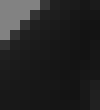

In [25]:
Gray.(1 .- A) # fun! More accurate parameter combinations are darker

In [26]:
A # rows are C, cols are γ

11×10 Matrix{Float64}:
 0.49125  0.49125  0.49125  0.49125  …  0.89125  0.895    0.91125  0.89375
 0.49125  0.49125  0.49125  0.79875     0.89375  0.91     0.915    0.915
 0.49125  0.49125  0.79875  0.87375     0.90625  0.91375  0.92     0.925
 0.49125  0.80125  0.87375  0.88625     0.91125  0.91875  0.92375  0.9225
 0.80125  0.87375  0.88625  0.89375     0.9125   0.91875  0.925    0.915
 0.87375  0.8875   0.89375  0.9      …  0.915    0.92     0.92625  0.91
 0.8875   0.89375  0.89875  0.905       0.9175   0.92     0.91625  0.9125
 0.89375  0.89875  0.905    0.90625     0.92     0.91875  0.91125  0.91125
 0.89875  0.905    0.90625  0.91        0.91875  0.92125  0.90125  0.8825
 0.905    0.905    0.90625  0.91125     0.92     0.92375  0.90625  0.87375
 0.905    0.905    0.91     0.9125   …  0.91875  0.9175   0.91125  0.86875

### What is the best SVM model?
Let's find the model with the highest training accuracy. We'll call this the _best model_ and save it in the `best_model::LIBSVM.SVM` variable. First, which element of the accuracy matrix $\mathbf{A}$ holds the maximum?
* We can estimate maximum accuracy element of the matrix $\mathbf{A}$ [using the `maximum(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.maximum). The `(i,j)` position of the maximum element can be computed using [the `argmax(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.argmax). The [`argmax(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) returns a cool data structure [called a `CartesianIndex`](https://docs.julialang.org/en/v1/base/arrays/#Base.IteratorsMD.CartesianIndex) which holds the (`row, col`) values of the maximum. This data structure is a way to model collection indices (which seems interesting!)

In [28]:
coordinate = argmax(A)
best_accuracy = maximum(A)
println("Best test accuracy: $(best_accuracy)")

Best test accuracy: 0.92625


In [55]:
coordinate

CartesianIndex(6, 9)

Next, get the best parameters, and save these in the `C_best::Float64` and `γ_best::Float64` variables:

In [63]:
C_best, γ_best = let
    
    C = coordinate[1] |> i-> α[i] |> e-> 2.0^e; # Wow! we grab the row (corresponds to C), get the exponent from α, and then compute the value
    γ = coordinate[2] |> i-> β[i] |> e-> 2.0^e; # Nice! grab the col (corresponds to γ), get the exponent from β, and then compute the value

    C,γ
end

(32.0, 2.0)

Finally, estimate the `best_model::LIBSVM.SVM`, the best predicted label vector `ŷ_test_best::Array{Int64,1}`, and the actual label vector `y_test::Array{Int64,1}` using the best parameters:

In [32]:
best_model, ŷ_test_best, y_test = let

    # Training data setup -
    D₁ = training; # what dataset are we looking at?
    number_of_training_examples = size(D₁,1); # how many rows?
    X₁ = [D₁[:,1:end-1] ones(number_of_training_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y₁ = D₁[:,end]; # label

    # Test data setup -
    D₂ = test; # what dataset are we looking at?
    number_of_test_examples = size(D₂,1); # how many rows?
    X₂ = [D₂[:,1:end-1] ones(number_of_test_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y₂ = D₂[:,end]; # label

    # estimate the best model -
    best_model = svmtrain(X₁, y₁, kernel=LIBSVM.Kernel.RadialBasis, 
                    verbose = false, cost = C_best, gamma = γ_best)
    

    # compute the ŷ_best -
    ŷ_best, _ = svmpredict(best_model,X₂);

    # return -
    best_model, ŷ_best, y₂
end;

Confirm the accuracy of the `best_model::LIBSVM.`:

In [65]:
accuracy_best_confirm = confusion(y_test, ŷ_test_best) |> CM -> CM[1,1] + CM[2,2] |> correct -> correct/size(test,1) # impressive!
@assert best_accuracy == accuracy_best_confirm

### DQs
1. What factors influence the prediction accuracy of the kSVM? For example, do the number of features influence performance or the fraction of random points? Let's run a few cases with different parameters and develop some intuition.